In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# read in the data
df = pd.read_csv("./../data/supervised_1_1.csv")

In [4]:
# format data
# take only the the oil price
# predict the final 30 days
# save the test and train data

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
df.set_index('date', inplace=True)
print(df.shape)
df.head()

(7316300, 21)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,...,rotterdam,brent,wti,eurusd,vehicles,state,station,global_mean,state_mean,num_days
date,,,,,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622837,109.424042,101.258553,1.369886,15211.0,10,0,1.546131,1.561237,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622486,109.699997,101.669998,1.369580,9146.0,10,0,1.560708,1.578196,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.622136,109.699997,101.669998,1.369580,9843.0,10,0,1.564237,1.581731,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.621785,109.838928,102.008537,1.370161,13502.0,10,0,1.563935,1.581525,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,...,0.620475,109.522926,102.058907,1.368282,12876.0,10,0,1.566228,1.582620,4


In [7]:
# try removing the averages so as to not include endogenous variables on the rigth hand side
df.drop(['global_mean', 'state_mean', 'eurusd', 'vehicles'], axis=1, inplace=True)
print(df.shape)
df.head()

(7316300, 17)


,e5gas,weekday,latitude,longitude,dautobahn,autobahn,aral,esso,jet,shell,total,rotterdam,brent,wti,state,station,num_days
date,,,,,,,,,,,,,,,,,
2014-05-16,1.536647,5,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622837,109.424042,101.258553,10,0,0
2014-05-17,1.564000,6,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622486,109.699997,101.669998,10,0,1
2014-05-18,1.569417,0,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.622136,109.699997,101.669998,10,0,2
2014-05-19,1.578167,1,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.621785,109.838928,102.008537,10,0,3
2014-05-20,1.599000,2,51.157501,10.0002,14850.392578,0,0,0,0,0,0,0.620475,109.522926,102.058907,10,0,4


In [8]:
rot = df['rotterdam'][:575]
brent = df['brent'][:575]
wti = df['wti'][:575]

Predict Rotterdam

In [81]:
# define rot_X as lagged one day and rot_y as rot
rot_y = rot.copy()
rot_x = rot.copy()
# pop the first observation on rot_y and the last on rot_x
rot_y.drop(['2014-05-16'], inplace=True)
rot_x.drop(['2015-12-11'], inplace=True)
# take last 30 days as test
train_rot_x = rot_x[:-31]
train_rot_y = rot_y[:-31]
test_rot_x = rot_x[-31:]
test_rot_y = rot_y[-31:]
# grab the values
v_train_rot_x = train_rot_x.values
v_train_rot_y = train_rot_y.values
v_test_rot_x = test_rot_x.values
v_test_rot_y = test_rot_y.values
#fit random forest
rot_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rot_model.fit(v_train_rot_x.reshape(543,1), v_train_rot_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [82]:
# make a prediction
rot_yhat = rot_model.predict(v_test_rot_x.reshape(31,1))

In [83]:
rot_rmse = sqrt(mean_squared_error(test_rot_y, rot_yhat))
rot_rmse

0.012910337834319998

Now, for Brent.

In [90]:
# define brent_X as lagged one day and brent_y as brent
brent_y = brent.copy()
brent_x = brent.copy()
# pop the first observation on brent_y and the last on brent_x
brent_y.drop(['2014-05-16'], inplace=True)
brent_x.drop(['2015-12-11'], inplace=True)
# take last 30 days as test
train_brent_x = brent_x[:-31]
train_brent_y = brent_y[:-31]
test_brent_x = brent_x[-31:]
test_brent_y = brent_y[-31:]
# grab the values
v_train_brent_x = train_brent_x.values
v_train_brent_y = train_brent_y.values
v_test_brent_x = test_brent_x.values
v_test_brent_y = test_brent_y.values
#fit random forest
brent_model = RandomForestRegressor(max_depth=20, random_state=0, n_estimators=10)
brent_model.fit(v_train_brent_x.reshape(543,1), v_train_brent_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [91]:
brent_yhat = brent_model.predict(v_test_brent_x.reshape(31,1))

In [92]:
brent_rmse = sqrt(mean_squared_error(test_brent_y, brent_yhat))
brent_rmse

2.2317526692115615

In [100]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np

In [105]:
lag_acf = acf(rot, nlags=30)
lag_pacf = pacf(rot, nlags=30, method='ols')

Text(0.5,1,'Autocorrelation Function')

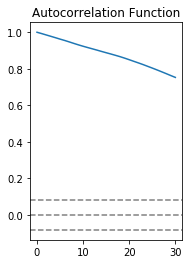

In [106]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rot)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

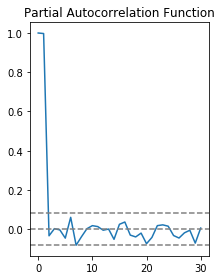

In [107]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(rot)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(rot)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [115]:
model = ARIMA(rot, order=(30, 0, 0))  
results_AR = model.fit(disp=-1) 

/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


KeyboardInterrupt: 

In [ ]:
results_AR.fittedvalues